<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/AutoencoderBasico_64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import PIL
import cv2
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

Nos descargamos las imágenes con un ancho de 256 de ancho. Vamos a ir escalando a 64, 128 y 256. Lo haremos con cv2.resize()

In [2]:
IMG_SIZE = 64

In [3]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

2022-06-21 15:36:33 URL:https://uc5cb9ac68036ca2aaa4790e94c4.dl.dropboxusercontent.com/cd/0/inline2/BnrbjNkz_oHbrNgTffLDZT2BD9rtpH6XjzZdKfxgaeOcHqG9wLYQRKE6MyaPbncRL3btzWIScibdXFpybeQiwoHXDWZgK-5TdBS4v4011tJcO4BlP1O7vFLbsynreW72LrSFFF-D-o32T-DTMNG5wLVjCKSaysoeMNd06U3FSyKGHAJIaolKTgy4MGbEWDQk96PrsPYme-L0GCf9dAI_INcM6KEyBgd4pHjUvl0Wxvbx-cLR6LiUi6qV4DrgSe3tf6_4dDgzP89S0vtgQr_44l0onscnGR1Pas9CCDGceRD_XC7kb0Sw6BHG-M814SsGV61iaw9DWsIIwG57rBLDxq7TK-f_OKxAna_0-qRurEhI3o3Nmy94tqd7F_gmSkRdQYj4QVRN9TiVrVn68NJ3bE5H5PL-D02NcnCmzWzDa3Oy9w/file [138777773/138777773] -> "train.zip" [1]
2022-06-21 15:36:35 URL:https://uc0a9bcf7fa086b218e31db17a0b.dl.dropboxusercontent.com/cd/0/inline2/BnoSdil9x6yqsnyVyGWko1Ryvb57r0Cv9zHxt6KU19k8mDrLvbsgBqkZkTLSbaY9WgkTYbeahoBxdYG-cYdX8PGN_HOGTGn04-cJWmnMf7wMlp21HAXpMXoUTHW7a0Gk4Sf34eLrHN5JG6WhvSyl9hCJGmcZr1bQ1R1265HqqCWGIyAZlgrytloNTuk1YjmRSfT7kcWXTHNf-ppJ-FIewMdKDERtpf7x4trMuzI7mwvQXdLKj7IpQKOVtKDgu7Kf2OLX3QLziOIH1VI-OLEWIM-_q7KkqZVufuTtM0c11jo7RXbiNFo_joiNCyBbxBwSHxC

In [4]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

In [63]:
#Método para crear estructura de directorios
def crearEstructura(nombreDataset, clases):
  !mkdir "$nombreDataset"
  !mkdir "$nombreDataset"/test
  !mkdir "$nombreDataset"/train
  !mkdir "$nombreDataset"/val
  for x in clases:
    !mkdir "$nombreDataset"/train/"$x"
    !mkdir "$nombreDataset"/test/"$x"
    !mkdir "$nombreDataset"/val/"$x"

crearEstructura('dataset', ['normal', 'enfermedad'])

In [20]:
trainPath = 'Training_Set_Pre/'
testPath  = 'Test_Set_Pre/'
valPath  =  'Evaluation_Set_Pre/'

In [24]:
dirsTrain = os.listdir( trainPath +  'Training/')
dirsTest = os.listdir( testPath + 'Test/')
dirsVal = os.listdir( valPath + 'Validation/')

In [67]:
import shutil

def moverImg(df, pathO, pathD):
  for id, enf in zip(df['ID'], df['Disease_Risk']):
    image = cv2.imread(pathO + '/' + str(id) + '.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    if(int(enf)==0):
      cv2.imwrite(pathD + '/normal/' + str(id) + '.png', cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else:
      cv2.imwrite(pathD + '/enfermedad/' + str(id) + '.png', cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [68]:
df_train = pd.read_csv(trainPath + '/train.csv')
df_test = pd.read_csv(testPath + '/test.csv')
df_val = pd.read_csv(valPath + '/val.csv')

In [34]:
path = 'dataset'

In [69]:
moverImg(df_train, trainPath + 'Training/', path  + '/train')
moverImg(df_test, testPath + 'Test/', path  + '/test')
moverImg(df_val, valPath + 'Validation/', path  + '/val')

Ya la tenemos reescalada a la medida deseada:

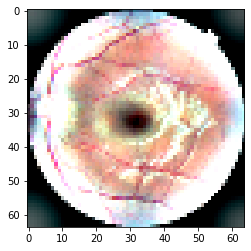

In [80]:
plt.imshow(cv2.cvtColor(cv2.imread(path  + '/train/normal/10.png'), cv2.COLOR_BGR2RGB))

In [89]:
img = cv2.imread(path  + '/train/normal/10.png')
img.shape

(64, 64, 3)

## Autoencoder

In [81]:
input_img = layers.Input(shape=(64,64,3))

### Encoder

In [82]:
# Capa convolucional con 32 filtros de tamaño 3x3 seguida de una función de activación relu y aplicando padding
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
# Capa de max pooling con filtro de tamaño 2x2 y aplicando padding
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

### Decoder

In [83]:
# Capa convolucional con 32 filtros de tamaño 3x3 seguida de una función de activación relu y aplicando padding
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
 # Capa de upsampling con filtro de tamaño 2x2 y aplicando padding
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [84]:
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [90]:
autoencoder.fit(img, img,
                epochs=50,
                batch_size=128)

Epoch 1/50


ValueError: ignored